Grovers search started at: 2024-05-21 21:04:41.049916
Grovers search ended at: 2024-05-21 21:04:41.052416
0:00:00.002392
--- 0.46029186248779297 seconds ---
{'0110': 47, '0000': 61, '1011': 48, '0010': 50, '1010': 52, '0111': 44, '0011': 48, '0001': 45, '1100': 50, '0100': 41, '1000': 167, '1110': 42, '1111': 39, '1101': 61, '0101': 48, '1001': 181}


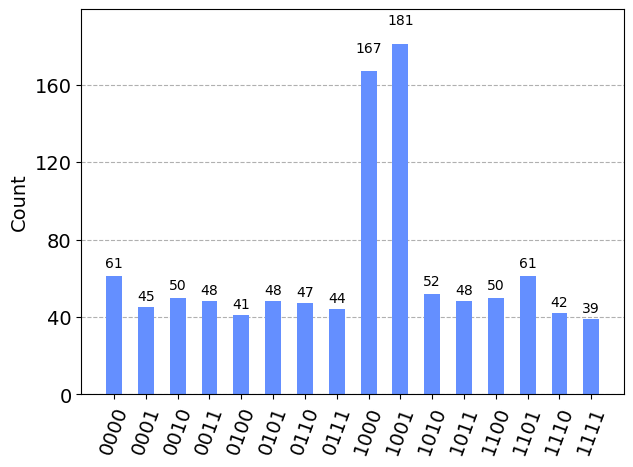

In [1]:
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.visualization import plot_histogram
import math
import time
from datetime import datetime
import psutil


def hadamard_transform(circ, my_wires):
    for wire in my_wires:
        circ.h(wire)
        
def oracle(circ, combos):
    for combo in combos:
        for i, bit in enumerate(combo):
            if bit == 0:
                circ.x(query_register[i])
    
        circ.mcx(query_register, aux)

        for i, bit in enumerate(combo):
            if bit == 0:
                circ.x(query_register[i])

def diffusion(circ):
    hadamard_transform(circ, query_register)
    circ.x(query_register)
    circ.h(query_register[-1])
    circ.mcx(query_register[:-1], query_register[-1])
    circ.h(query_register[-1])
    circ.x(query_register)
    hadamard_transform(circ, query_register)
    #print(circ.draw())

def grovers_search_iteration(circ, optimal_iterations):
    print(f"Grovers search started at: {datetime.now()}")
    time1 = datetime.now()
    circ.x(aux)
    hadamard_transform(circ, list(range(n_bits + 1)))
    for _ in range(optimal_iterations):
        oracle(circ, combo)
        diffusion(circ)
    
    for i in range(n_bits):
        circ.measure(query_register[i], i)
        
    time2 = datetime.now()
    print(f"Grovers search ended at: {datetime.now()}")
    print(time2-time1)
    return circ

start_time = time.time()

n_bits = 4
circ = QuantumCircuit(n_bits + 1, n_bits)
query_register = list(range(n_bits))
aux = n_bits
combo = [[1,0,0,1], [0,0,0,1]]

N = 2**n_bits
m = len(combo)
optimal_iterations = int((math.pi / 4) * math.sqrt(N))
#optimal_iterations = 1

grovers_search_iteration(circ, optimal_iterations)

process = psutil.Process()
#print(process.memory_info().rss)

backend = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()
counts = result.get_counts()
print("--- %s seconds ---" % (time.time() - start_time))
#print(circ)
print(counts)
plot_histogram(counts)

In [3]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.visualization import plot_histogram
import math
import time
from datetime import datetime
import psutil

def hadamard_transform(circ, my_wires):
    for wire in my_wires:
        circ.h(wire)

def oracle(circ, query_register, aux, combo):
    for i, bit in enumerate(combo):
        if bit == 0:
            circ.x(query_register[i])
    circ.mcx(query_register, aux)
    for i, bit in enumerate(combo):
        if bit == 0:
            circ.x(query_register[i])

def diffusion(circ, query_register):
    hadamard_transform(circ, query_register)
    circ.x(query_register)
    circ.h(query_register[-1])
    circ.mcx(query_register[:-1], query_register[-1])
    circ.h(query_register[-1])
    circ.x(query_register)
    hadamard_transform(circ, query_register)

def grovers_search_iteration(circ, query_register, aux, combo, optimal_iterations):
    time1 = datetime.now()
    circ.x(aux)
    hadamard_transform(circ, list(range(len(query_register) + 1)))
    for _ in range(optimal_iterations):
        oracle(circ, query_register, aux, combo)
        diffusion(circ, query_register)
    circ.measure(query_register, range(len(query_register)))
    time2 = datetime.now()
    print(time2-time1)
    return circ

def find_all_solutions(n_bits, combos):
    results = {}
    backend = Aer.get_backend('aer_simulator')
    query_register = list(range(n_bits))
    aux = n_bits
    N = 2**n_bits

    remaining_combos = combos.copy()

    for combo in combos:
        circ = QuantumCircuit(n_bits + 1, n_bits)
        m = len(remaining_combos)
        optimal_iterations = int((math.pi / 4) * math.sqrt(N)) if m > 0 else 1
        
        grovers_search_iteration(circ, query_register, aux, combo, optimal_iterations)
        transpiled_circuit = transpile(circ, backend)
        result = backend.run(transpiled_circuit).result()
        counts = result.get_counts()
        found_solution = max(counts, key=counts.get)
        
        #print(circ)
        
        results["".join(map(str, combo))] = counts
        remaining_combos.remove(combo)
        
        print(f"Found solution for {combo}: {found_solution}")
        plot_histogram(counts)
        plt.show()
    

    return results

start_time = time.time()

n_bits = 4
combos = [[0,0,0,0], [1,0,0,1]]

results = find_all_solutions(n_bits, combos)
for solution, counts in results.items():
    max_value = max(counts, key=counts.get)
    #print(f"Results for {solution}: {counts}")
    print(f"Most common result for {solution}: {max_value} with {counts[max_value]} occurrences")
    print(counts[max_value] / 1024 * 100)

    
print("--- %s seconds ---" % (time.time() - start_time))


0:00:00.002260
Found solution for [0, 0, 0, 0]: 0000
0:00:00.001583
Found solution for [1, 0, 0, 1]: 1001
Most common result for 0000: 0000 with 979 occurrences
95.60546875
Most common result for 1001: 1001 with 989 occurrences
96.58203125
--- 0.10296416282653809 seconds ---
